<a href="https://colab.research.google.com/github/sayonp/sayonp/blob/main/UMM_Puri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install momepy
!pip install libpysal
!pip install osmnx
!pip install Clustergram

In [ ]:
import warnings

import geopandas
import libpysal
import momepy
import osmnx
import pandas

from clustergram import Clustergram

import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bokeh.plotting import show

output_notebook()

In [ ]:
path = '/content/'
!pwd

/content


## Importing Buildings

In [ ]:
buildings = geopandas.read_file(path + 'puri_buildings.shp')

Streaming output truncated to the last 5000 lines.
ERROR:fiona._env:Error in fread() reading object of size 168 at offset 5409496 from .shp file
ERROR:fiona._env:Error in fread() reading object of size 168 at offset 5409664 from .shp file
ERROR:fiona._env:Error in fread() reading object of size 136 at offset 5409832 from .shp file
ERROR:fiona._env:Error in fread() reading object of size 168 at offset 5409968 from .shp file
ERROR:fiona._env:Error in fread() reading object of size 152 at offset 5410136 from .shp file
ERROR:fiona._env:Error in fread() reading object of size 136 at offset 5410288 from .shp file
ERROR:fiona._env:Error in fread() reading object of size 168 at offset 5410424 from .shp file
ERROR:fiona._env:Error in fread() reading object of size 136 at offset 5410592 from .shp file
ERROR:fiona._env:Error in fread() reading object of size 136 at offset 5410728 from .shp file
ERROR:fiona._env:Error in fread() reading object of size 136 at offset 5410864 from .shp file
ERROR:fio

In [ ]:
buildings["uID"] = range(len(buildings))

In [ ]:
buildings.head()

,FID,geometry,uID
0,0,"POLYGON ((373636.166 2188214.044, 373635.821 2...",0
1,1,"POLYGON ((373647.821 2188209.274, 373646.714 2...",1
2,2,"POLYGON ((373646.540 2188214.571, 373646.229 2...",2
3,3,"POLYGON ((373649.996 2188213.859, 373649.061 2...",3
4,4,"POLYGON ((373645.909 2188217.062, 373644.786 2...",4


### Scatterplot for Polygon distribution

<Axes: >

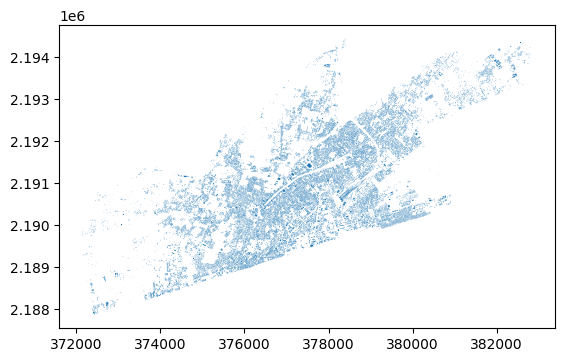

In [ ]:
buildings.plot()

In [ ]:
buildings.geom_type.value_counts()

Polygon         54181
MultiPolygon        3
dtype: int64

In [ ]:
buildings = buildings[buildings.geom_type == "Polygon"].reset_index(drop=True)

In [ ]:
#local_crs = 1514
#buildings = buildings[["geometry"]].to_crs(local_crs)

NameError: ignored

In [ ]:
buildings["uID"] = range(len(buildings))
buildings.head()

,FID,geometry,uID
0,0,"POLYGON ((373636.166 2188214.044, 373635.821 2...",0
1,1,"POLYGON ((373647.821 2188209.274, 373646.714 2...",1
2,2,"POLYGON ((373646.540 2188214.571, 373646.229 2...",2
3,3,"POLYGON ((373649.996 2188213.859, 373649.061 2...",3
4,4,"POLYGON ((373645.909 2188217.062, 373644.786 2...",4


## Importing Streets

In [ ]:
streets = geopandas.read_file(path + 'puri_buildings.dbf')

In [ ]:
streets = momepy.remove_false_nodes(streets)
streets = streets[["geometry"]]
streets["nID"] = range(len(streets))

<Axes: >

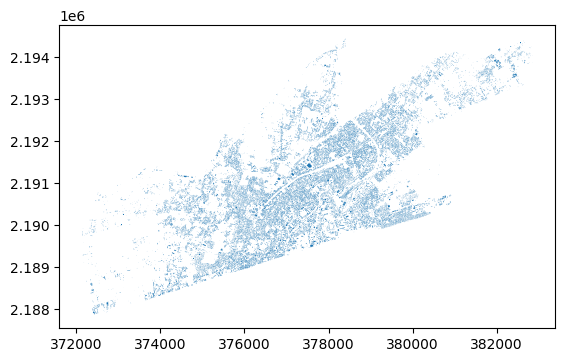

In [ ]:
streets.head()
streets.plot()


## Generated Data: Tessellation

In [ ]:
limit = momepy.buffered_limit(buildings, 100)

tessellation = momepy.Tessellation(buildings, "uID", limit, verbose=False, segment=1)
tessellation = tessellation.tessellation



<ipython-input-18-8aed5e3e8989>:3: UserWarning: Tessellation does not fully match buildings. 13 element(s) collapsed during generation - unique_id: {48198, 9159, 2122, 403, 53525, 29848, 9113, 51428, 53156, 33513, 33514, 33709, 9138}.
  tessellation = momepy.Tessellation(buildings, "uID", limit, verbose=False, segment=1)
<ipython-input-18-8aed5e3e8989>:3: UserWarning: Tessellation contains MultiPolygon elements. Initial objects should  be edited. `unique_id` of affected elements: [39352, 39383, 439, 453, 39492, 39529, 74, 39549, 39539, 222, 306, 39543, 641, 663, 755, 2002, 2193, 2214, 2049, 1499, 1545, 1565, 2357, 2426, 2545, 2583, 3043, 2563, 2770, 3126, 2270, 2267, 2306, 2849, 4247, 2490, 2752, 2869, 4844, 4518, 5067, 920, 948, 1028, 1372, 1555, 1546, 1694, 1881, 3132, 3151, 2631, 3948, 3993, 4018, 4139, 4140, 4823, 3487, 5464, 4779, 4879, 4790, 8284, 3339, 3475, 3784, 39764, 3730, 39888, 4927, 5853, 5595, 8246, 8365, 8383, 8348, 8511, 7412, 7481, 39799, 7745, 11941, 7902, 12179, 100

<Axes: >

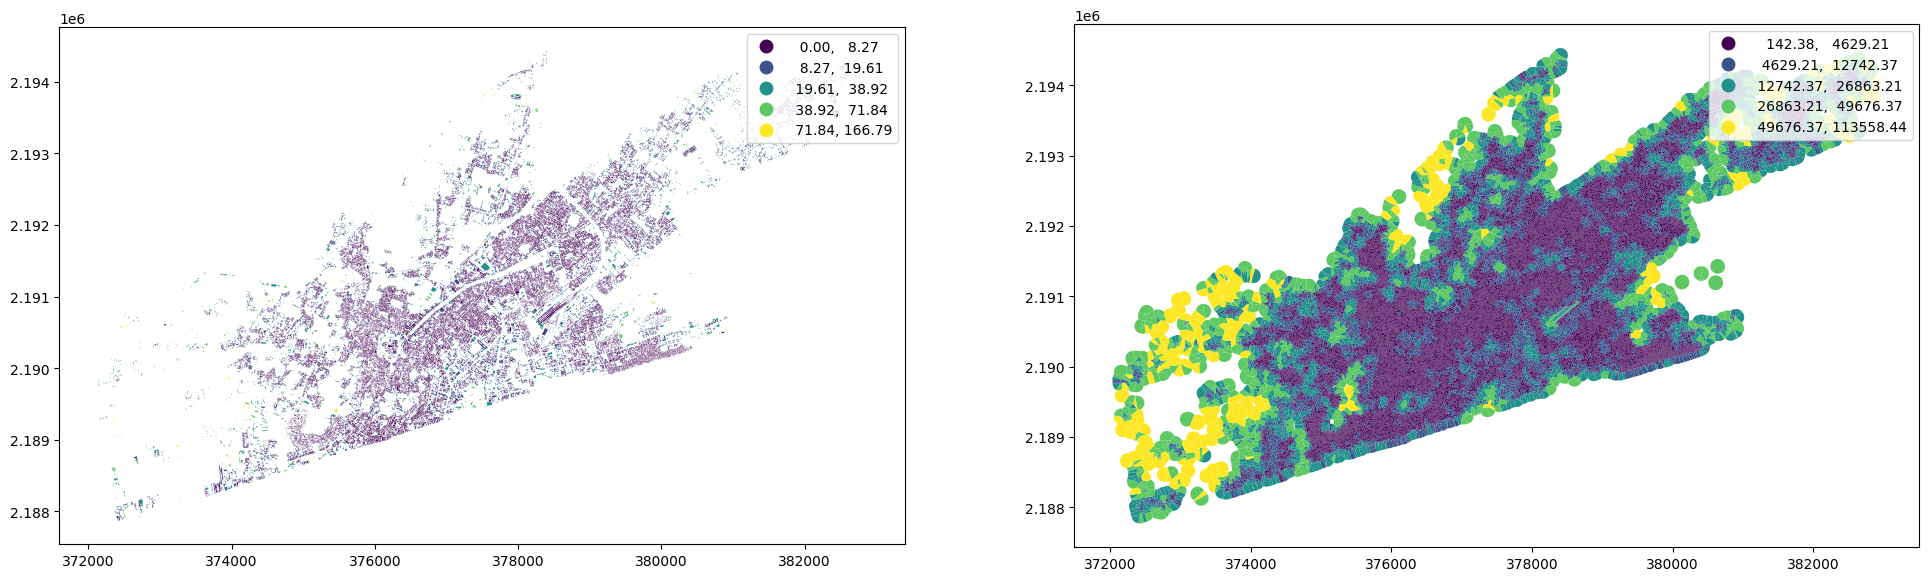

In [ ]:
queen_1 = libpysal.weights.contiguity.Queen.from_dataframe(tessellation, ids="uID", silence_warnings=True)
tessellation["covered_area"] = momepy.CoveredArea(tessellation, queen_1, "uID", verbose=False).series
buildings["neighbor_distance"] = momepy.NeighborDistance(buildings, queen_1, "uID", verbose=False).series
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
buildings.plot("neighbor_distance", ax=ax[0], scheme="natural_breaks", legend=True)
tessellation.plot("covered_area", ax=ax[1], scheme="natural_breaks", legend=True)

### Link Streets

In [ ]:
buildings = buildings.sjoin_nearest(streets, max_distance=1000, how="left")
buildings.head()

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:2298: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3514
Right CRS: PROJCS["unknown",GEOGCS["GCS_unknown",DATUM["WGS_1 ...

  return geopandas.sjoin_nearest(


,geometry,uID,index_right,nID
0,"POLYGON ((12702339.100 10175744.359, 12702336....",0,NaN,NaN
1,"POLYGON ((12702344.764 10175755.835, 12702341....",1,NaN,NaN
2,"POLYGON ((12702339.303 10175754.914, 12702336....",2,NaN,NaN
3,"POLYGON ((12702340.271 10175758.367, 12702337....",3,NaN,NaN
4,"POLYGON ((12702336.734 10175754.452, 12702332....",4,NaN,NaN


In [ ]:
buildings = buildings.drop_duplicates("uID").drop(columns="index_right")
tessellation = tessellation.merge(buildings[['uID', 'nID']], on='uID', how='left')

## Measure: Dimensions

In [ ]:
buildings["area"] = buildings.area
tessellation["area"] = tessellation.area
streets["length"] = streets.length
print(buildings)

                                                geometry    uID  nID  \
0      POLYGON ((12702339.100 10175744.359, 12702336....      0  NaN   
1      POLYGON ((12702344.764 10175755.835, 12702341....      1  NaN   
2      POLYGON ((12702339.303 10175754.914, 12702336....      2  NaN   
3      POLYGON ((12702340.271 10175758.367, 12702337....      3  NaN   
4      POLYGON ((12702336.734 10175754.452, 12702332....      4  NaN   
...                                                  ...    ...  ...   
54176  POLYGON ((12696775.723 10180352.935, 12696770....  54176  NaN   
54177  POLYGON ((12696762.598 10180350.432, 12696773....  54177  NaN   
54178  POLYGON ((12696770.311 10180351.988, 12696762....  54178  NaN   
54179  POLYGON ((12696770.191 10180388.578, 12696761....  54179  NaN   
54180  POLYGON ((12696763.604 10180385.230, 12696759....  54180  NaN   

             area  
0        7.148759  
1      124.637985  
2        9.023027  
3       15.683685  
4       14.012298  
...           .

### Shape

In [ ]:
#print(momepy.EquivalentRectangularIndex(buildings))
buildings['eri'] = momepy.EquivalentRectangularIndex(buildings).series.apply(lambda x: x[0])
buildings['elongation'] = momepy.Elongation(buildings).series.apply(lambda x: x[0])
tessellation['convexity'] = momepy.Convexity(tessellation).series.apply(lambda x: x[0])
streets["linearity"] = momepy.Linearity(streets).series.apply(lambda x: x[0])


ValueError: ignored

In [ ]:
!pip install mapclassify

In [1]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("eri", ax=ax[0], scheme="natural_breaks", legend=True)
buildings.plot("elongation", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

NameError: name 'plt' is not defined

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
ax[0].set_axis_off()


### Spatial Distribution

In [ ]:
buildings["shared_walls"] = momepy.SharedWallsRatio(buildings).series
buildings.plot("shared_walls", figsize=(12, 20), scheme="natural_breaks", legend=True).set_axis_off()

In [ ]:
queen_1 = libpysal.weights.contiguity.Queen.from_dataframe(tessellation, ids="uID", silence_warnings=True)

In [ ]:
tessellation["neighbors"] = momepy.Neighbors(tessellation, queen_1, "uID", weighted=True, verbose=False).series
tessellation["covered_area"] = momepy.CoveredArea(tessellation, queen_1, "uID", verbose=False).series

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    buildings["neighbor_distance"] = momepy.NeighborDistance(buildings, queen_1, "uID", verbose=False).series

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("neighbor_distance", ax=ax[0], scheme="natural_breaks", legend=True)
tessellation.plot("covered_area", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

In [ ]:
queen_3 = momepy.sw_high(k=3, weights=queen_1)
buildings_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings, silence_warnings=True)

buildings['interbuilding_distance'] = momepy.MeanInterbuildingDistance(buildings, queen_1, 'uID', queen_3, verbose=False).series
buildings['adjacency'] = momepy.BuildingAdjacency(buildings, queen_3, 'uID', buildings_q1, verbose=False).series

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("adjacency", ax=ax[0], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()

### Intensity

In [ ]:
tessellation['car'] = momepy.AreaRatio(tessellation, buildings, 'area', 'area', 'uID').series
tessellation.plot("car", figsize=(12, 12), vmin=0, vmax=1, legend=True).set_axis_off()